<a href="https://colab.research.google.com/github/Eieiz007/Deep-learning/blob/main/Transformer_model_stock_nvidia_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is my mini project.  
Nvidia Stock time series forcasting by Transformer model   

# PIP

In [ ]:
# !pip install torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.1 MB/s eta 0:00:00


In [ ]:
# pip install yfinance

# Import

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
import torch.optim as optim


# API datasets

In [ ]:
stocks = ["NVDA"]
df = yf.download(stocks, period="5y")[['Open', 'High', 'Low', 'Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.columns = [f"Price_{col}" for col in df.columns]
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df[:].columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [ ]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2020-03-02,6.897723,6.914911,6.501646,6.886015,890744000
2020-03-03,6.941815,7.001600,6.538016,6.623459,652792000
2020-03-04,6.730822,7.096757,6.656090,7.087291,597408000
2020-03-05,6.887759,7.054660,6.763206,6.807796,540328000
2020-03-06,6.628192,6.685736,6.426915,6.627196,515412000
...,...,...,...,...,...
2025-02-24,136.559998,138.589996,130.080002,130.279999,251381100
2025-02-25,129.979996,130.199997,124.440002,126.629997,271428700
2025-02-26,129.990005,133.729996,128.490005,131.279999,322553800


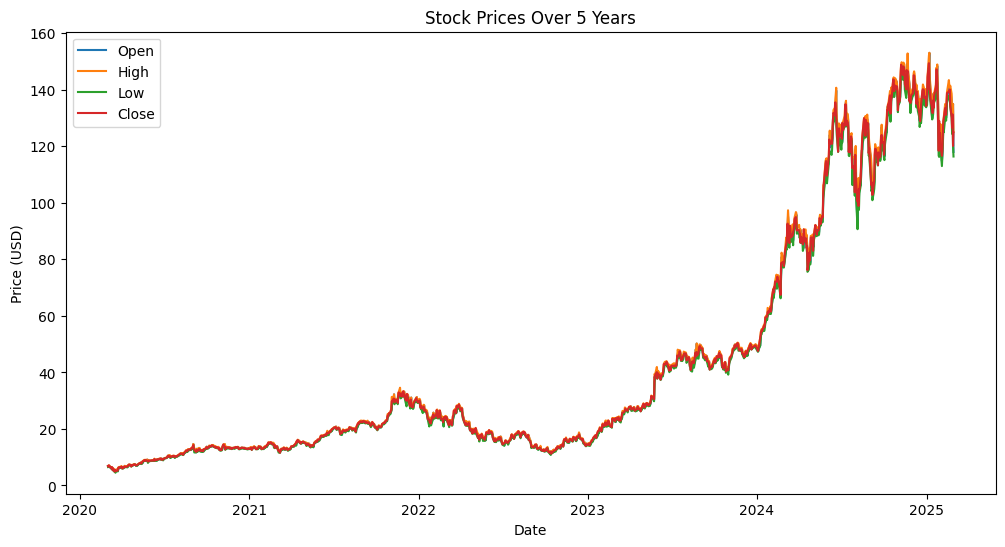

In [ ]:
plt.figure(figsize=(12, 6))
for stock in ['Open', 'High', 'Low', 'Close']:
    plt.plot(df[stock], label=stock)
plt.legend()
plt.title("Stock Prices Over 5 Years")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

# Data cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-03-02 to 2025-02-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1257 non-null   float64
 1   High    1257 non-null   float64
 2   Low     1257 non-null   float64
 3   Close   1257 non-null   float64
 4   Volume  1257 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.9 KB


In [ ]:
df.describe()

,Open,High,Low,Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,42.423927,43.205568,41.537656,42.402577,4.413781e+08
std,41.265153,41.973613,40.346512,41.170577,1.854443e+08
min,4.984596,5.229715,4.500834,4.892426,9.788400e+07
25%,14.126034,14.338359,13.855730,14.142094,3.025899e+08
50%,22.370725,22.754037,21.963474,22.345095,4.177350e+08
75%,48.218089,48.743898,47.581511,48.122128,5.431120e+08
max,153.029999,153.130005,147.820007,149.429993,1.543911e+09


# 1.Missing Values

In [ ]:
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


# 2.Check Datetime Index

In [ ]:
df = df.sort_index()
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2020-03-02,6.897725,6.914913,6.501647,6.886016,890744000
2020-03-03,6.941814,7.001599,6.538014,6.623457,652792000
2020-03-04,6.730823,7.096758,6.656091,7.087292,597408000
2020-03-05,6.887760,7.054661,6.763207,6.807797,540328000
2020-03-06,6.628192,6.685736,6.426915,6.627196,515412000


# Seasonality decompostion

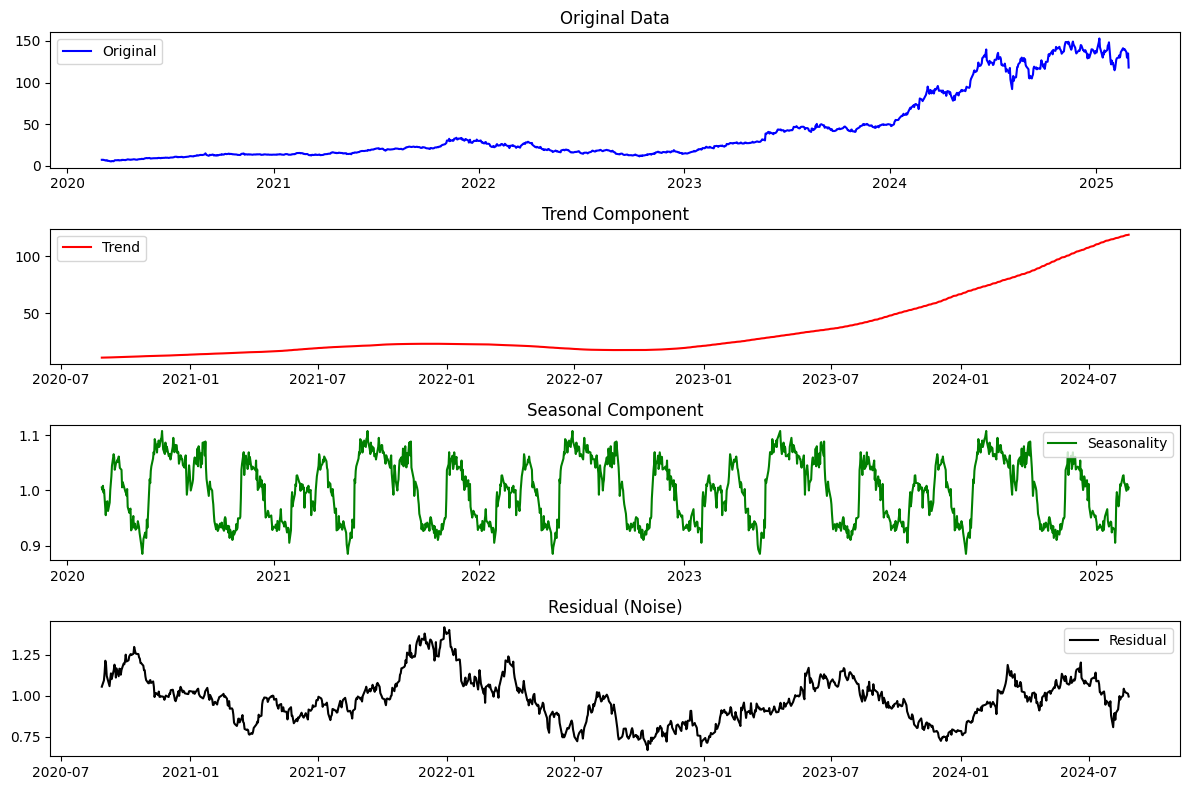

In [ ]:
stock = "Open"
decomposition = sm.tsa.seasonal_decompose(df[stock], model="multiplicative", period=252)  # 252 วัน = 1 ปีในตลาดหุ้น

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df[stock], label="Original", color="blue")
plt.title("Original Data")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label="Trend", color="red")
plt.title("Trend Component")
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label="Seasonality", color="green")
plt.title("Seasonal Component")
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label="Residual", color="black")
plt.title("Residual (Noise)")
plt.legend()

plt.tight_layout()
plt.show()

# ADF Statistic Test

In [ ]:
def check_stationarity(series):
    print(series.reset_index().columns[1])
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("data not is Stationary (p < 0.05)")
        print(" ")
    else:
        print("data is Stationary (p >= 0.05)")
        print(" ")

check_stationarity(df["Open"])

Open
ADF Statistic: -0.03941907988477052
p-value: 0.955148193233813
data is Stationary (p >= 0.05)
 


# Data prepartation for train model

In [ ]:
# --- CONFIG ---
LOOKBACK = 30
HORIZON = 7

features = df.columns.tolist()
target_col = 'Open'  # 'target'
features.remove(target_col)

# StandardScaler

In [ ]:
# Standardization
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

df[features] = scaler_X.fit_transform(df[features])
df[target_col] = scaler_Y.fit_transform(df[[target_col]])

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Volume'}>, <Axes: >]], dtype=object)

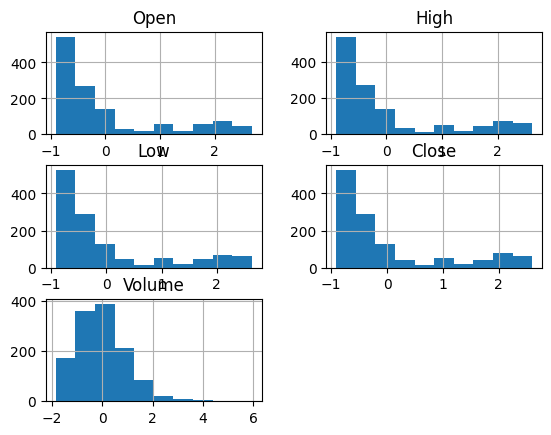

In [ ]:
df.hist()

# Data Splitting

In [ ]:
#(encoder_input, decoder_input, decoder_output) lookback 30 , predict 7
def create_sequences(df, lookback, horizon):
    X_enc, X_dec, Y_dec = [], [], []

    for i in range(len(df) - lookback - horizon):
        encoder_input = df.iloc[i:i+lookback][features].values                        # i=1:0-29  , i=2:1-30
        decoder_input = df.iloc[i+lookback-1:i+lookback+horizon-1][target_col].values # i=1:29-36 , i=2:30-37
        decoder_output = df.iloc[i+lookback:i+lookback+horizon][target_col].values    # i=1:30-37 , i=2:31-38

        X_enc.append(encoder_input)
        X_dec.append(decoder_input)
        Y_dec.append(decoder_output)

    return np.array(X_enc), np.array(X_dec), np.array(Y_dec)

X_enc, X_dec, Y_dec = create_sequences(df, LOOKBACK, HORIZON)
print(X_enc.shape , X_dec.shape , Y_dec.shape)

#Encoder เรียนรู้จากอดีต → ส่ง context ไปให้ Decoder
#Decoder input คือค่าจริงในอดีตเล็กน้อยที่ "ช่วยเริ่มต้น" ให้ Decoder
#Decoder output คือค่าที่ต้องการให้ Decoder ทำนาย (target จริง)

(1220, 30, 4) (1220, 7) (1220, 7)


In [ ]:
# 70 15 15
X_enc_train, X_enc_temp, X_dec_train, X_dec_temp, Y_dec_train, Y_dec_temp = train_test_split(
    X_enc, X_dec, Y_dec, test_size=0.2, random_state=42, shuffle=False
)

X_enc_val, X_enc_test, X_dec_val, X_dec_test, Y_dec_val, Y_dec_test = train_test_split(
    X_enc_temp, X_dec_temp, Y_dec_temp, test_size=0.5, random_state=42, shuffle=False
)

# Torch_tensor

In [ ]:
# Tensor
X_enc_train = torch.tensor(X_enc_train, dtype=torch.float32)
X_dec_train = torch.tensor(X_dec_train, dtype=torch.float32).unsqueeze(-1)
Y_dec_train = torch.tensor(Y_dec_train, dtype=torch.float32).unsqueeze(-1)

X_enc_val = torch.tensor(X_enc_val, dtype=torch.float32)
X_dec_val = torch.tensor(X_dec_val, dtype=torch.float32).unsqueeze(-1)
Y_dec_val = torch.tensor(Y_dec_val, dtype=torch.float32).unsqueeze(-1)

X_enc_test = torch.tensor(X_enc_test, dtype=torch.float32)
X_dec_test = torch.tensor(X_dec_test, dtype=torch.float32).unsqueeze(-1)
Y_dec_test = torch.tensor(Y_dec_test, dtype=torch.float32).unsqueeze(-1)

print("Train shape:", X_enc_train.shape, X_dec_train.shape, Y_dec_train.shape)
print("Val shape:", X_enc_val.shape, X_dec_val.shape, Y_dec_val.shape)
print("Test shape:", X_enc_test.shape, X_dec_test.shape, Y_dec_test.shape)

Train shape: torch.Size([976, 30, 4]) torch.Size([976, 7, 1]) torch.Size([976, 7, 1])
Val shape: torch.Size([122, 30, 4]) torch.Size([122, 7, 1]) torch.Size([122, 7, 1])
Test shape: torch.Size([122, 30, 4]) torch.Size([122, 7, 1]) torch.Size([122, 7, 1])


# Config model

In [ ]:
# --- CONFIG ---
CONFIG = {
    "num_features": X_enc_train.shape[2],
    "d_model": 32,  # ลดขนาด embedding เพื่อลดพารามิเตอร์
    "num_heads": 4,  # ลด Attention Head เพื่อลด Complexity
    "num_encoder_layers": 3,  # ลดจำนวน layers
    "num_decoder_layers": 3,
    "dim_feedforward": 512,  # ลดขนาด hidden layer ใน FFN
    "dropout": 0.5,  # เพิ่ม Dropout
    "learning_rate": 0.0005,  # ลด Learning Rate
    "weight_decay": 1e-2,  # เพิ่ม Weight Decay (Regularization)
    "batch_size": 256,  # ลด Batch Size
    "num_epochs": 15,  # เพิ่ม Epoch เพราะเรียนรู้ช้าลง
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

print("Updated Config:", CONFIG)



Updated Config: {'num_features': 4, 'd_model': 32, 'num_heads': 4, 'num_encoder_layers': 3, 'num_decoder_layers': 3, 'dim_feedforward': 512, 'dropout': 0.5, 'learning_rate': 0.0005, 'weight_decay': 0.01, 'batch_size': 256, 'num_epochs': 15, 'device': device(type='cpu')}


# Architechture transformer

In [ ]:
class StockTransformer(nn.Module):
    def __init__(self, config):
        super(StockTransformer, self).__init__()
        self.d_model = config["d_model"]

        self.encoder_embedding = nn.Linear(config["num_features"], config["d_model"])
        self.decoder_embedding = nn.Linear(1, config["d_model"])

        # Transformer
        self.transformer = nn.Transformer(
            d_model=config["d_model"],
            nhead=config["num_heads"],
            num_encoder_layers=config["num_encoder_layers"],
            num_decoder_layers=config["num_decoder_layers"],
            dim_feedforward=config["dim_feedforward"],
            dropout=config["dropout"],
            batch_first=True  # PyTorch 1.10+
        )

        # Linear Layer
        self.fc_out = nn.Linear(config["d_model"], 1)

    def forward(self, encoder_input, decoder_input):
        """
        encoder_input: (batch, LOOKBACK, num_features)
        decoder_input: (batch, HORIZON, 1)
        """

        # Embed input -> (batch, seq_len, d_model)
        enc_embed = self.encoder_embedding(encoder_input)
        dec_embed = self.decoder_embedding(decoder_input)

        # Transformer Forward Pass
        transformer_out = self.transformer(enc_embed, dec_embed)

        # Fully Connected Layer
        output = self.fc_out(transformer_out)  # (batch, HORIZON, 1)
        return output

# สร้างโมเดล
model = StockTransformer(CONFIG).to(CONFIG["device"])
summary(model, input_size=[(32, 30, CONFIG["num_features"]), (32, 7, 1)], col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
StockTransformer                                   [32, 30, 4]               [32, 7, 1]                --
├─Linear: 1-1                                      [32, 30, 4]               [32, 30, 32]              160
├─Linear: 1-2                                      [32, 7, 1]                [32, 7, 32]               64
├─Transformer: 1-3                                 [32, 30, 32]              [32, 7, 32]               --
│    └─TransformerEncoder: 2-1                     [32, 30, 32]              [32, 30, 32]              --
│    │    └─ModuleList: 3-1                        --                        --                        112,992
│    │    └─LayerNorm: 3-2                         [32, 30, 32]              [32, 30, 32]              64
│    └─TransformerDecoder: 2-2                     [32, 7, 32]               [32, 7, 32]               --
│    │    └─ModuleList: 3-3        

# DataLoader

In [ ]:
train_dataset = TensorDataset(X_enc_train, X_dec_train, Y_dec_train)
val_dataset = TensorDataset(X_enc_val, X_dec_val, Y_dec_val)

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

Train batches: 4, Val batches: 1


# Training

In [ ]:

# Loss Function (Mean Squared Error)
criterion = nn.MSELoss()

# Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])  # ปรับ weight_decay


In [ ]:
train_losses = []
val_losses = []

for epoch in range(CONFIG["num_epochs"]):
    model.train()
    train_loss = 0.0

    for X_enc, X_dec, Y_dec in train_loader:
        X_enc, X_dec, Y_dec = X_enc.to(CONFIG["device"]), X_dec.to(CONFIG["device"]), Y_dec.to(CONFIG["device"])
        optimizer.zero_grad()
        output = model(X_enc, X_dec)
        loss = criterion(output, Y_dec)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_enc, X_dec, Y_dec in val_loader:
            X_enc, X_dec, Y_dec = X_enc.to(CONFIG["device"]), X_dec.to(CONFIG["device"]), Y_dec.to(CONFIG["device"])
            output = model(X_enc, X_dec)
            loss = criterion(output, Y_dec)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

Epoch 1: Train Loss=0.4630, Val Loss=0.8958
Epoch 2: Train Loss=0.2196, Val Loss=0.4050
Epoch 3: Train Loss=0.1652, Val Loss=0.4560
Epoch 4: Train Loss=0.1189, Val Loss=0.4166
Epoch 5: Train Loss=0.0964, Val Loss=0.3011
Epoch 6: Train Loss=0.0870, Val Loss=0.2569
Epoch 7: Train Loss=0.0771, Val Loss=0.2689
Epoch 8: Train Loss=0.0695, Val Loss=0.2789
Epoch 9: Train Loss=0.0682, Val Loss=0.2693
Epoch 10: Train Loss=0.0615, Val Loss=0.2658
Epoch 11: Train Loss=0.0560, Val Loss=0.2803
Epoch 12: Train Loss=0.0524, Val Loss=0.2655
Epoch 13: Train Loss=0.0522, Val Loss=0.2376
Epoch 14: Train Loss=0.0499, Val Loss=0.2257
Epoch 15: Train Loss=0.0474, Val Loss=0.2237


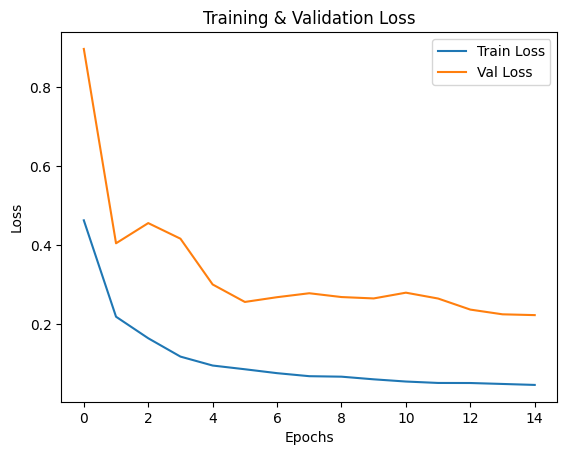

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

# LSTM

In [ ]:
df = df[['Open']]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

def create_sequences(data, input_size=30, output_size=7):
    X, y = [], []
    for i in range(len(data) - input_size - output_size):
        X.append(data[i:i+input_size])
        y.append(data[i+input_size:i+input_size+output_size])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, input_size=30, output_size=7)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: torch.Size([854, 30, 1]), y_train: torch.Size([854, 7, 1])
X_val: torch.Size([183, 30, 1]), y_val: torch.Size([183, 7, 1])
X_test: torch.Size([183, 30, 1]), y_test: torch.Size([183, 7, 1])


In [ ]:
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # 🔹 LSTM Layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)

        # 🔹 Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # Output ทั้ง sequence

        # 🔥 แก้ตรงนี้ให้ output 7 วัน
        out = self.fc(out[:, -7:, :])  # ใช้ 7 วันสุดท้ายของ sequence

        return out


In [ ]:
# 🔹 ทดลอง forward pass
model = StockLSTM(input_dim=1, hidden_dim=128, num_layers=2, output_dim=7)

In [ ]:
import torch.optim as optim

# 🔹 Loss Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 🔹 Training Loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

F, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # 🔹 Validate
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([854, 7, 1])) that is different to the input size (torch.Size([854, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([183, 7, 1])) that is different to the input size (torch.Size([183, 7, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Train Loss: 0.3138, Val Loss: 0.5906
Epoch 2/10, Train Loss: 0.3120, Val Loss: 0.5924
Epoch 3/10, Train Loss: 0.3102, Val Loss: 0.5943
Epoch 4/10, Train Loss: 0.3084, Val Loss: 0.5961
Epoch 5/10, Train Loss: 0.3066, Val Loss: 0.5979
Epoch 6/10, Train Loss: 0.3049, Val Loss: 0.5997
Epoch 7/10, Train Loss: 0.3032, Val Loss: 0.6015
Epoch 8/10, Train Loss: 0.3014, Val Loss: 0.6034
Epoch 9/10, Train Loss: 0.2996, Val Loss: 0.6052
Epoch 10/10, Train Loss: 0.2979, Val Loss: 0.6071
